In [1]:
#import monai
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
from transformers import SamModel, SamConfig, SamProcessor
import torch
#import cv2
#from torchvision.ops import focal_loss

/Users/ryantenbarge/.pyenv/versions/3.10.6/envs/solar_potential_map/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Useful reference links:
https://chenriang.me/f1-equal-dice-coefficient.html



https://medium.com/mlearning-ai/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f

In [2]:
def import_data(folder) -> np.array:
    """
    Import images from specified local folder
    Returns a list of arrays
    """

    #get all file names
    file_names = glob.glob(f'../data_for_ml/{folder}/*.png')
    file_names = sorted(file_names)
    #sort file names


    #storing all the np.array images
    folder_images = []

    i = 1
    for file in file_names:
        #import each picture from folder
        im = Image.open(file)
        #resize w pillow!!
        im = im.resize((256, 256))
        # #append to list as an array
        folder_images.append(np.asarray(im, dtype=np.uint8))

        #just a counter to see how fast it's moving
        print(f"Completed {i} images")
        i+=1

    return folder_images

Load in the original images

In [3]:
gray = import_data(folder= '../data_for_ml/renamed_gray')

Completed 1 images
Completed 2 images
Completed 3 images
Completed 4 images
Completed 5 images
Completed 6 images
Completed 7 images
Completed 8 images
Completed 9 images
Completed 10 images
Completed 11 images
Completed 12 images
Completed 13 images
Completed 14 images
Completed 15 images
Completed 16 images
Completed 17 images
Completed 18 images
Completed 19 images
Completed 20 images
Completed 21 images
Completed 22 images
Completed 23 images
Completed 24 images
Completed 25 images
Completed 26 images
Completed 27 images
Completed 28 images
Completed 29 images
Completed 30 images
Completed 31 images
Completed 32 images
Completed 33 images
Completed 34 images
Completed 35 images
Completed 36 images
Completed 37 images
Completed 38 images
Completed 39 images
Completed 40 images
Completed 41 images
Completed 42 images
Completed 43 images
Completed 44 images
Completed 45 images
Completed 46 images
Completed 47 images
Completed 48 images
Completed 49 images
Completed 50 images
Completed

In [4]:
original = import_data(folder= '../data_for_ml/original')

Completed 1 images
Completed 2 images
Completed 3 images
Completed 4 images
Completed 5 images
Completed 6 images
Completed 7 images
Completed 8 images
Completed 9 images
Completed 10 images
Completed 11 images
Completed 12 images
Completed 13 images
Completed 14 images
Completed 15 images
Completed 16 images
Completed 17 images
Completed 18 images
Completed 19 images
Completed 20 images
Completed 21 images
Completed 22 images
Completed 23 images
Completed 24 images
Completed 25 images
Completed 26 images
Completed 27 images
Completed 28 images
Completed 29 images
Completed 30 images
Completed 31 images
Completed 32 images
Completed 33 images
Completed 34 images
Completed 35 images
Completed 36 images
Completed 37 images
Completed 38 images
Completed 39 images
Completed 40 images
Completed 41 images
Completed 42 images
Completed 43 images
Completed 44 images
Completed 45 images
Completed 46 images
Completed 47 images
Completed 48 images
Completed 49 images
Completed 50 images
Completed

Make sure the imgaes loaded in correctly

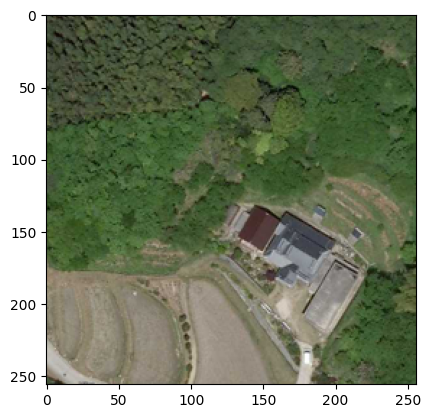

In [86]:
plt.imshow(original[1])

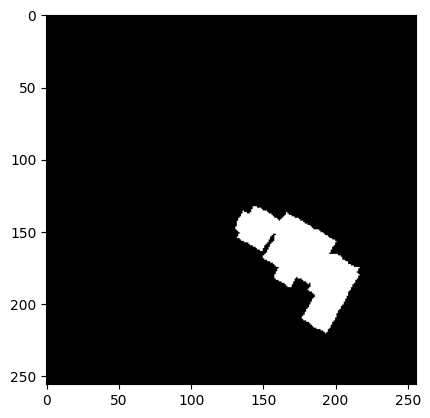

In [87]:
plt.imshow(gray[1],cmap='gray')

Make 2 large arrays

In [7]:
original_np = np.array(original)
grays_np = np.array(gray)

Delete empty masks

In [8]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(gray) if mask.max() != 0]

# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = original_np[valid_indices]
filtered_masks = grays_np[valid_indices]

print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (4058, 256, 256, 3)
Mask shape: (4058, 256, 256)


# Train/Test Split

In [9]:
train_percent = filtered_images.shape[0] * 0.8
train_percent = np.round(train_percent, 0).astype('int8')

training_split_img = filtered_images[:train_percent, :, :, :]
training_split_mask = filtered_masks[:train_percent, :, :]

test_split_img= filtered_images[train_percent:, :, :, :]
test_split_mask= filtered_masks[train_percent:, :, :]

In [10]:
print(training_split_img.shape)
print(test_split_img.shape)
print(training_split_mask.shape)
print(test_split_mask.shape)

(3976, 256, 256, 3)
(82, 256, 256, 3)
(3976, 256, 256)
(82, 256, 256)


Mask Prediction Function - Play around with grid_size and mask_prob threshold.

In [11]:
def predict_mask(model, image:np.array) -> np.array:
    """Takes in a retrained SAM model and a google earth
    satellite image in numpy array format of any size and outputs a black and white image
    corresponding to rooftop masks. Output size is 256 by 256 pixels."""
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
    if type(image) != np.array:
        image_array = np.array(image)
    else:
        image_array = image
    array_size = image_array.shape[0]
    # Higher grid sizes seem to confuse the model and decrease performance
    grid_size = 10
    # Generate grid points which will serve as prompt for SAM
    x = np.linspace(0, array_size-1, grid_size)
    y = np.linspace(0, array_size-1, grid_size)
    # Generate a grid of coordinates
    xv, yv = np.meshgrid(x, y)
    # Convert the numpy arrays to lists
    xv_list = xv.tolist()
    yv_list = yv.tolist()
    # Combine the x and y coordinates into a list of list of lists
    input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]
    #We need to reshape our nxn grid to the expected shape of the input_points tensor
    # (batch_size, point_batch_size, num_points_per_image, 2),
    # where the last dimension of 2 represents the x and y coordinates of each point.
    #batch_size: The number of images you're processing at once.
    #point_batch_size: The number of point sets you have for each image.
    #num_points_per_image: The number of points in each set.
    input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    inputs = processor(image_array, input_points=input_points, return_tensors="pt")
    # Move the input tensor to the GPU if it's not already there
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.eval()
    # forward pass
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)
    # apply sigmoid
    mask_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    mask_prob = mask_prob.cpu().numpy().squeeze()
    mask_prediction = (mask_prob > 0.5).astype(np.uint8)
    return mask_prediction

In [12]:
def load_model_locally(path):
    """Loads retrained SAM model weights from local file
    and returns model ready to make a prediction"""
    # Load the model configuration
    model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
    # Create an instance of the model architecture with the loaded configuration
    model = SamModel(config=model_config)
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    return model

In [13]:
model = load_model_locally('../retrain_weights/train_test_split.pth')

In [27]:
random_prediction = predict_mask(model, test_split_img[10])

In [28]:
print(random_prediction.shape)
print(test_split_mask[10].shape)

(256, 256)
(256, 256)


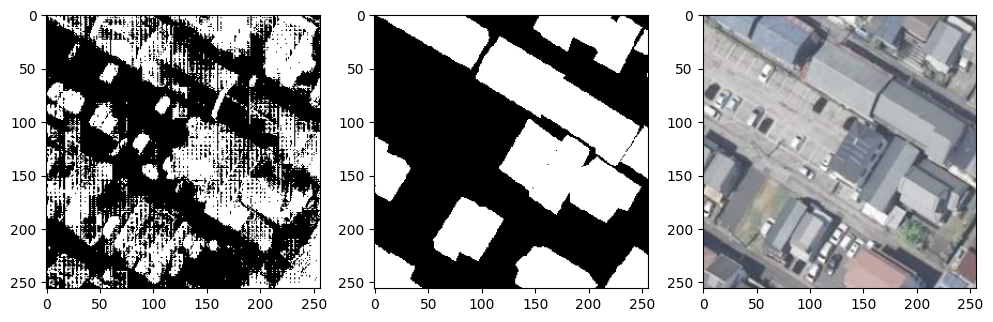

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
ax[0].imshow(random_prediction, cmap='gray')
ax[1].imshow(test_split_mask[10], cmap='gray')
ax[2].imshow(test_split_img[10])

In [30]:
test_split_img.shape

(82, 256, 256, 3)

There are 82 images in our test split and 82 corresponding masks. Let's choose a random one just to confirm.

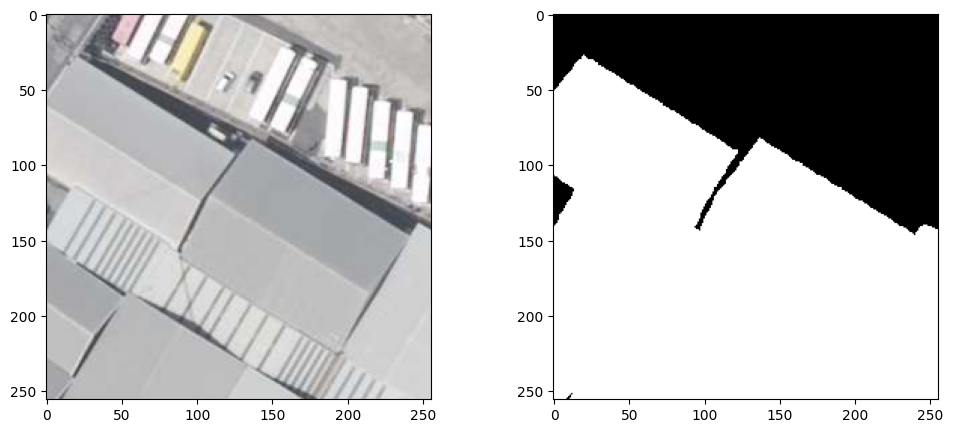

In [83]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,5))
ax[0].imshow(test_split_img[15])
ax[1].imshow(test_split_mask[15], cmap='gray')


In [32]:
answer = test_split_mask[10]
correct_pixels = np.logical_and(random_prediction, answer).sum()
pixel_acuracy = (correct_pixels/256**2)*100
print(f'Pixel accuracy is {round(pixel_acuracy,2)}% for test image at index 10.')

Pixel accuracy is 23.3% for test image at index 10.


In [33]:
def true_positive(target, prediction):
    positive = 1
    return np.sum(np.logical_and(prediction==positive, target==positive))

def true_negative(target, prediction):
    negative = 0
    return np.sum(np.logical_and(prediction==negative, target==negative))

def false_positive(target, prediction):
    negative = 0
    positive = 1
    return np.sum(np.logical_and(prediction==positive, target==negative))

def false_negative(target, prediction):
    negative = 0
    positive = 1
    return np.sum(np.logical_and(prediction==negative, target==positive))

In [43]:
# Function to get pixel accuracy of 256x256 mask prediction
def accuracy(target, prediction):
    return (np.logical_and(target, prediction).sum())/target.sum()

In [40]:
# Function to get basic precision score
def precision_score(target, prediction):
    tp = true_positive(target, prediction)
    fp = false_positive(target, prediction)
    return tp/(tp+fp)

In [50]:
pres = precision_score(answer, random_prediction)
print(f'Calcuated precision of image at index 10: {pres*100}%')

Calcuated precision of image at index 10: 59.031160596922604%


In [37]:
#Function to get IoU score
def IoU_Score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [38]:
iou = IoU_Score(answer, random_prediction)
print(f'IoU Score for Image at index 10: {iou}')

IoU Score for Image at index 10: 0.3958160514309415


In [46]:
# Function to get dice coeffiecient metric
def dice_coef(target, prediction):
    intersect = np.sum(prediction*target)
    total_sum = np.sum(prediction) + np.sum(target)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

In [47]:
dice = dice_coef(answer, random_prediction)
print(f'Dice score for Image at index 10: {dice}')

Dice score for Image at index 10: 0.567


Let's check our metrics. If we pass in the original mask for both the target and prediction params, we should get perfect scores if our metrics are correctly defined.

In [39]:
iou_test = IoU_Score(answer, answer)
print(f'IoU score of original mask against original mask {iou_test}')

IoU score of original mask against original mask 1.0


In [41]:
precision_test = precision_score(answer, answer)
print(f'Precision of original mask against original mask {precision_test}')

Precision of original mask against original mask 1.0


In [44]:
accuracy_test = accuracy(answer, answer)
print(f'Accuracy score of original mask against original mask {accuracy_test}')

Accuracy score of original mask against original mask 1.0


In [48]:
dice_test = dice_coef(answer, answer)
print(f'Dice Coeff (F-1 Score) of original mask against original mask {dice_test}')

Dice Coeff (F-1 Score) of original mask against original mask 1.0


It looks like all 4 metrics are correctly defined now. Let's find the average metrics for our entire test set using a for loop.

In [51]:
Iou_scores = []
precision_scores = []
accuracy_scores = []
dice_scores = []
for i in range(0,82):
    print(f'Working on image at index: {i}')
    test_image = test_split_img[i]
    test_answer = test_split_mask[i]
    prediction = predict_mask(model, test_image)
    precision = precision_score(test_answer, prediction)
    precision_scores.append(precision)
    acc = accuracy(test_answer, prediction)
    accuracy_scores.append(acc)
    iou = IoU_Score(test_answer, prediction)
    Iou_scores.append(iou)
    dice = dice_coef(test_answer, prediction)
    dice_scores.append(dice)

Working on image at index: 0
Working on image at index: 1
Working on image at index: 2
Working on image at index: 3
Working on image at index: 4
Working on image at index: 5
Working on image at index: 6
Working on image at index: 7
Working on image at index: 8
Working on image at index: 9
Working on image at index: 10
Working on image at index: 11
Working on image at index: 12
Working on image at index: 13
Working on image at index: 14
Working on image at index: 15
Working on image at index: 16
Working on image at index: 17
Working on image at index: 18
Working on image at index: 19
Working on image at index: 20
Working on image at index: 21
Working on image at index: 22
Working on image at index: 23
Working on image at index: 24
Working on image at index: 25
Working on image at index: 26
Working on image at index: 27
Working on image at index: 28
Working on image at index: 29
Working on image at index: 30
Working on image at index: 31
Working on image at index: 32
Working on image at 

# Let's examine the distributions of each scoring metric

Text(0.5, 1.0, 'Iou Score Distributions')

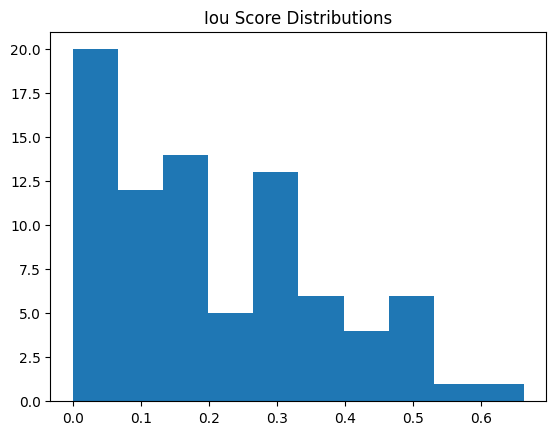

In [52]:
plt.hist(Iou_scores)
plt.title('Iou Score Distributions')

In [53]:
print(f'Mean Iou Score {np.array(Iou_scores).mean()}')

Mean Iou Score 0.20853184732385094


Text(0.5, 1.0, 'Precision Scores')

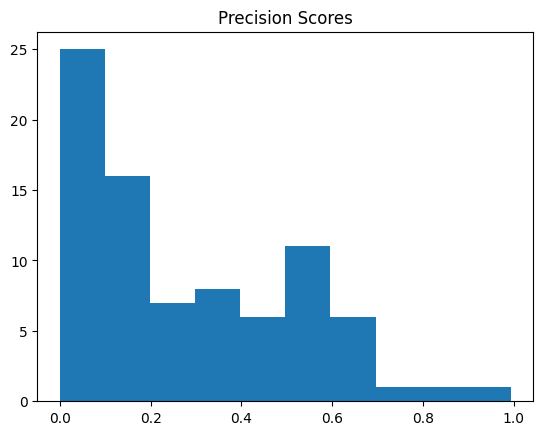

In [54]:
plt.hist(precision_scores)
plt.title('Precision Scores')

In [55]:
print(f'Mean Precision Score {np.array(precision_scores).mean()}')

Mean Precision Score 0.2817587958781792


Text(0.5, 1.0, 'Accuracy Scores')

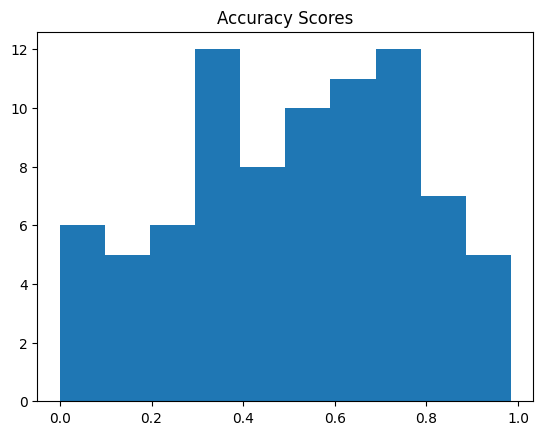

In [56]:
plt.hist(accuracy_scores)
plt.title('Accuracy Scores')

In [57]:
print(f'Mean Accuracy Score {np.array(accuracy_scores).mean()}')

Mean Accuracy Score 0.5103040800566876


Text(0.5, 1.0, 'Dice Score Distributions')

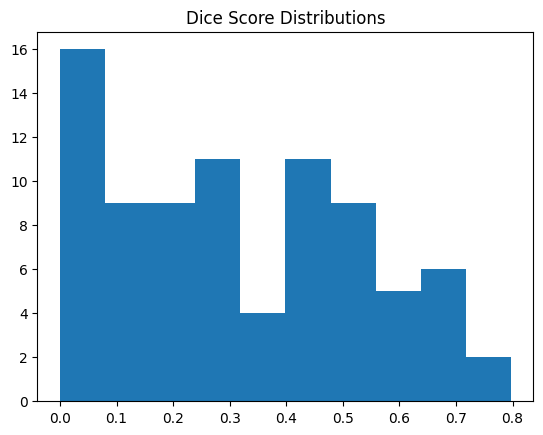

In [58]:
plt.hist(dice_scores)
plt.title('Dice Score Distributions')

In [59]:
print(f'Mean Dice/F-1 Score {np.array(dice_scores).mean()}')

Mean Dice/F-1 Score 0.31528048780487805


In [60]:
print(f'Mean Iou Score {np.array(Iou_scores).mean()}')
print(f'Mean Precision Score {np.array(precision_scores).mean()}')
print(f'Mean Accuracy Score {np.array(accuracy_scores).mean()}')
print(f'Mean Dice/F-1 Score {np.array(dice_scores).mean()}')

Mean Iou Score 0.20853184732385094
Mean Precision Score 0.2817587958781792
Mean Accuracy Score 0.5103040800566876
Mean Dice/F-1 Score 0.31528048780487805


# Let's see which images got the best scores for each metric.

In [66]:
print(f'Best IoU Score was at index {np.argmax(Iou_scores)}')
print(f'Best Precision score was at index {np.argmax(precision_scores)}')
print(f'Best Accuracy Score was at index {np.argmax(accuracy_scores)}')
print(f'Best Dice/F-1 Score was at index {np.argmax(dice_scores)}')

Best IoU Score was at index 18
Best Precision score was at index 17
Best Accuracy Score was at index 53
Best Dice/F-1 Score was at index 18


# Let's see what the images and respective masks at indices 17, 18, and 53 look like.

In [67]:
image_17 = test_split_img[17]
image_18 = test_split_img[18]
image_53 = test_split_img[53]

In [69]:
mask_17 = predict_mask(model=model, image=image_17)
mask_18 = predict_mask(model=model, image=image_18)
mask_53 = predict_mask(model=model, image=image_53)

Text(0.5, 1.0, 'Image 17 with Best Precision Score')

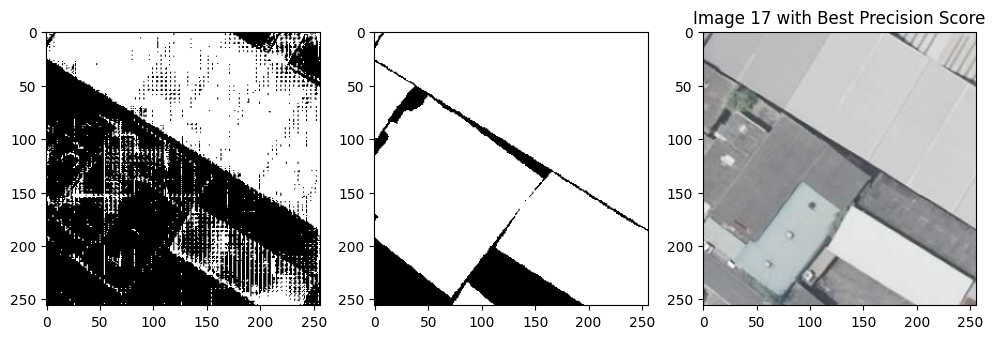

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
ax[0].imshow(mask_17, cmap='gray')
ax[1].imshow(test_split_mask[17], cmap='gray')
ax[2].imshow(image_17)
plt.title('Image 17 with Best Precision Score')

Text(0.5, 1.0, 'Image 18 with Best F-1 and IoU Scores')

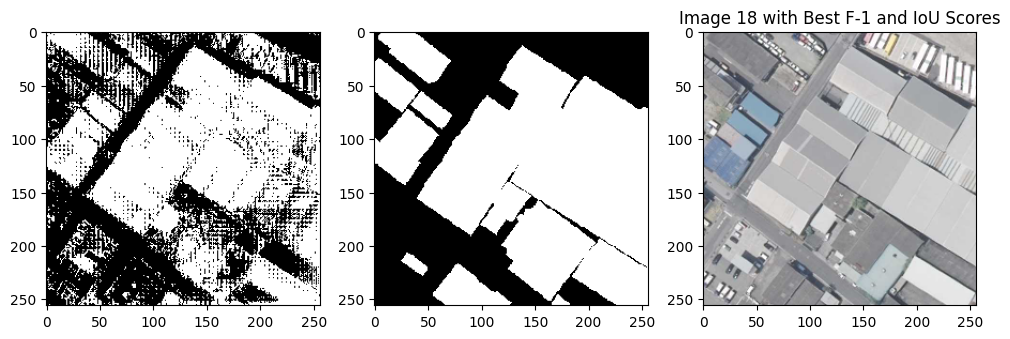

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
ax[0].imshow(mask_18, cmap='gray')
ax[1].imshow(test_split_mask[18], cmap='gray')
ax[2].imshow(image_18)
plt.title('Image 18 with Best F-1 and IoU Scores')

Text(0.5, 1.0, 'Image 53 with Best Accuracy Score')

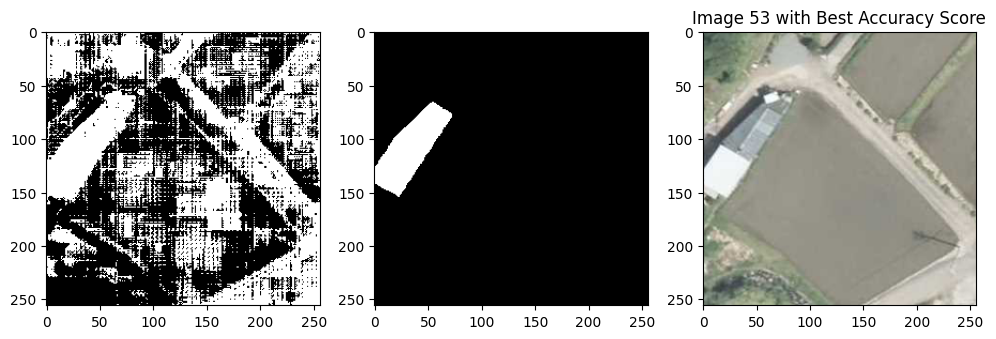

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
ax[0].imshow(mask_53, cmap='gray')
ax[1].imshow(test_split_mask[53], cmap='gray')
ax[2].imshow(image_53)
plt.title('Image 53 with Best Accuracy Score')

# Let's see finally which images were the worst performing.

In [75]:
print(f'Worst IoU Score was at index {np.argmin(Iou_scores)}')
print(f'Worst Precision score was at index {np.argmin(precision_scores)}')
print(f'Worst Accuracy Score was at index {np.argmin(accuracy_scores)}')
print(f'Worst Dice/F-1 Score was at index {np.argmin(dice_scores)}')

Worst IoU Score was at index 6
Worst Precision score was at index 6
Worst Accuracy Score was at index 6
Worst Dice/F-1 Score was at index 6


# Let's see what's going on in image 6 and try to avoid similar images in the demo.

In [76]:
mask_6 = predict_mask(model=model, image=test_split_img[6])

Text(0.5, 1.0, 'Image 6 with Worse Everything')

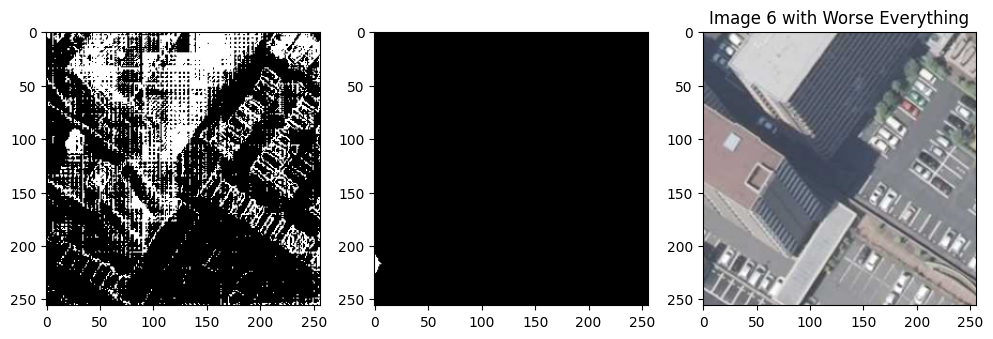

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
ax[0].imshow(mask_6, cmap='gray')
ax[1].imshow(test_split_mask[6], cmap='gray')
ax[2].imshow(test_split_img[6])
plt.title('Image 6 with Worse Everything')

# Image 6 makes sense due to the　普通建物　nature of our dataset. The two large buildings in this image are not 普通建物 and are thus confusing our model. Model confusion is unavoidable here.